<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/masstransferMeOH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Calculation of mass transfer and hydrate inhibition of a wet gas by injection of methanol
#@markdown Demonstration of mass transfer calculation using the NeqSim software in Python
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from neqsim.thermo import fluid, fluid_df
import pandas as pd
from neqsim.process import gasscrubber, clearProcess, run,nequnit, phasemixer, splitter, clearProcess, stream, valve, separator, compressor, runProcess, viewProcess, heater,saturator, mixer

plt.style.use('classic')
%matplotlib inline

#Mass transfer calculations
Model for mass transfer calculation in NeqSim based on Solbraa (2002):

https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/231326

In the following calculations we assume a water saturated gas the is mixed with pure liquid methanol. These phases are not in equiibrium when they enter the pipeline. When the gas and methanol liquid comes in contact in the pipeline, methanol will vaporize into the gas, and water (and other comonents from the gas) will be absorbed into the liquid methanol. The focus of the following calculations will be to evaluate the mass transfer as function of contanct length with gas and methanol. It also evaluates the hydrate temperature of the gas leaving the pipe section.






Figure 1 Illustration of mass transfer process

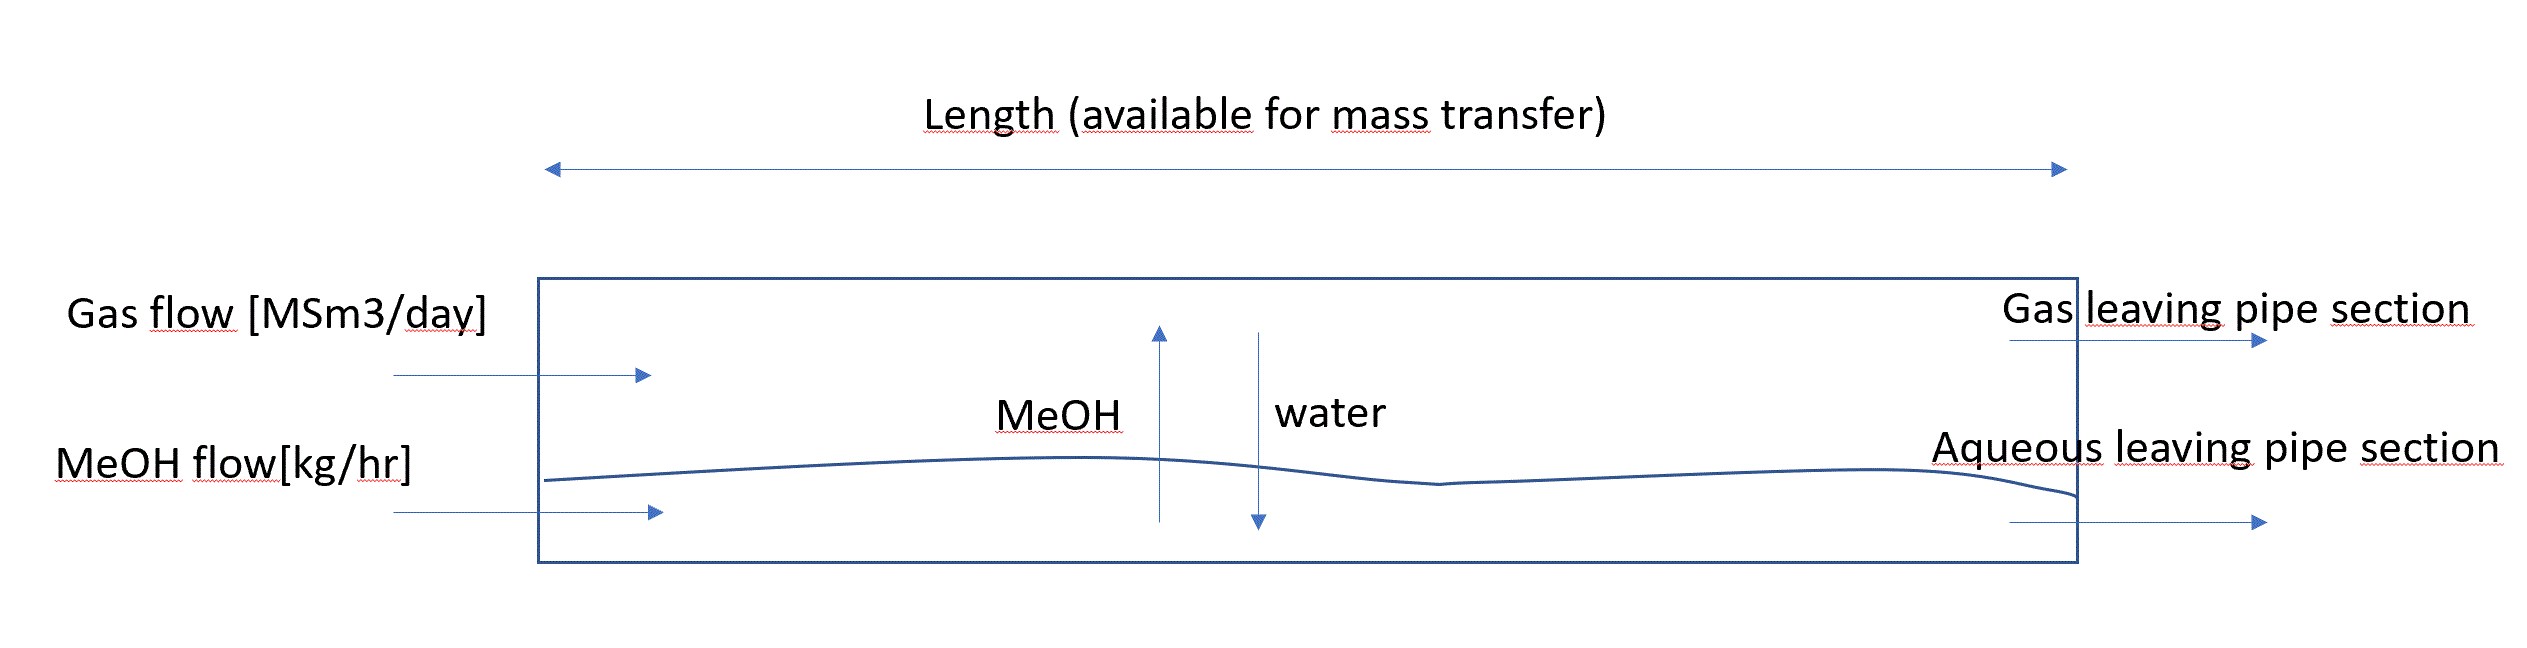

**The parameters for the model are:**

Temperature and pressure of the pipe (mass transfer calculated at constant temperature and pressure).

Length and diameter of pipe where gas and liquid will be in contact and mass transfer can occur.

Flow rate of the gas in MSm3/day, flow rate of methanol (kg/hr).

#Calculation of compostion of aqueous phase and gas leaving pipe section
In the following script we will simulate the composition of the gas leaving pipe section at a given pipe lengt.

In [ ]:
# Input parameters
pressure = 52.21 # bara
temperature = 15.2 #C
gasFlow = 1.23 #MSm3/day
methanolFlow = 6000.23 # kg/day

pipelength = 10.0 #meter
pipeInnerDiameter = 0.5 #meter

# Create a gas-condensate fluid
feedgas = {'ComponentName':  ["nitrogen","CO2","methane", "ethane" , "propane", "i-butane", "n-butane", "water", "methanol"],
        'MolarComposition[-]':  [0.01, 0.01, 0.8, 0.06, 0.01,0.005,0.005, 0.0, 0.0]
}

naturalgasFluid = fluid_df(pd.DataFrame(feedgas)).setModel("CPAs-SRK-EOS-statoil")
naturalgasFluid.setTotalFlowRate(gasFlow, "MSm3/day")
naturalgasFluid.setTemperature(temperature, "C")
naturalgasFluid.setPressure(pressure, "bara")

# Create a liquid methanol fluid
feedMeOH = {'ComponentName':  ["nitrogen","CO2","methane", "ethane" , "propane", "i-butane", "n-butane", "water", "methanol"],
        'MolarComposition[-]':  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,1.0]
}
meOHFluid = fluid_df(pd.DataFrame(feedMeOH) ).setModel("CPAs-SRK-EOS-statoil")
meOHFluid.setTotalFlowRate(methanolFlow, "kg/hr");
meOHFluid.setTemperature(temperature, "C");
meOHFluid.setPressure(pressure, "bara");

clearProcess()
dryinjectiongas = stream(naturalgasFluid)
MeOHFeed = stream(meOHFluid)
watersaturator = saturator(dryinjectiongas)
waterSaturatedFeedGas = stream(watersaturator.getOutStream())

mainMixer = phasemixer("gas MeOH mixer")
mainMixer.addStream(waterSaturatedFeedGas)
mainMixer.addStream(MeOHFeed)

pipeline = nequnit(mainMixer.getOutStream(), equipment="pipeline", flowpattern="stratified") #alternative flow patterns are: stratified, annular and droplet
pipeline.setLength(pipelength)
pipeline.setID(pipeInnerDiameter)

scrubber = gasscrubber(pipeline.getOutStream())
gasFromScrubber = stream(scrubber.getGasOutStream())
aqueousFromScrubber = stream(scrubber.getLiquidOutStream())
run()
print('Composition of gas leaving pipe section after ', pipelength, ' meter')
printFrame(gasFromScrubber.getFluid())
print('Composition of aqueous phase leaving pipe section after ', pipelength, ' meter')
printFrame(aqueousFromScrubber.getFluid())

print('Interface contact area ', pipeline.getInterfacialArea(), ' m^2')
print('Volume fraction aqueous phase ', pipeline.getOutStream().getFluid().getVolumeFraction(1), ' -')

# Calculation of hydrate equilibrium temperature of gas leaving pipe section
In the following script we will simulate the composition of the gas  leaving pipe section as well as hydrate equilibrium temperature of this gas as function of pipe length.

In [ ]:
maxpipelength = 10.0

def hydtemps(length):
    pipeline.setLength(length)
    run();
    return gasFromScrubber.getHydrateEquilibriumTemperature()-273.15

length = np.arange(0.01, maxpipelength, (maxpipelength)/10.0)
hydtem = [hydtemps(length2) for length2 in length]

plt.figure()
plt.plot(length, hydtem)
plt.xlabel('Length available for mass transfer [m]')
plt.ylabel('Hydrate eq.temperature [C]')
plt.title('Hydrate eq.temperature of gas leaving pipe section')

# Mass and heat transfer between lean TEG and dehydrated gas

The temperature profile between a liquid film and gas, and mass transfer rates of TEG, water is interested to simulate after injection of lean TEG in an absorber.

In [ ]:
from neqsim.neqsimpython import jNeqSim

fluid1 = jNeqSim.thermo.system.SystemSrkCPAstatoil(313.0, 150.0)

fluid1.addComponent('methane', 10.0,"MSm3/day", 0)
fluid1.addComponent('water', 1.0, "kg/hr", 0)
fluid1.addComponent('TEG', 0.125, "kg/hr", 0)
fluid1.addComponent('water', 10.0, "kg/hr", 1)
fluid1.addComponent('TEG', 1000.0, "kg/hr", 1)

fluid1.createDatabase(True)
fluid1.setMixingRule(10)
fluid1.initPhysicalProperties()

fluid1.getPhase(0).setTemperature(273.15+37.0)
fluid1.getPhase(1).setTemperature(273.15+47.9)
fluid1.init_x_y();
fluid1.initBeta();
fluid1.init(3);

#print('initial fluid:')
#printFrame(fluid1)

pipe1 = jNeqSim.fluidMechanics.geometryDefinitions.pipe.PipeData(2.5, 0.00025);
node1 = jNeqSim.fluidMechanics.flowNode.twoPhaseNode.twoPhasePipeFlowNode.AnnularFlow(fluid1,pipe1)
node1.setInterphaseModelType(1)
node1.setLengthOfNode(0.001);
node1.getGeometry().getSurroundingEnvironment().setTemperature(273.15 + 4.0);
node1.getFluidBoundary().setHeatTransferCalc(True)
node1.getFluidBoundary().setMassTransferCalc(True)
length = 0
node1.initFlowCalc()
node1.calcFluxes()

#printFrame(node1.getBulkSystem())
#printFrame(node1)

interphaseTemp =  []
gasTemp =  []
liqTemp =  []

TEGingas = []
wateringas = []
length = []
for i in range(100):
  length.append(i*0.001)
  interphaseTemp.append(node1.getInterphaseSystem().getTemperature('C'))
  gasTemp.append(node1.getBulkSystem().getPhase('gas').getTemperature()-273.15)
  liqTemp.append(node1.getBulkSystem().getPhase('aqueous').getTemperature()-273.15)
  TEGingas.append(node1.getBulkSystem().getPhase(0).getComponent('TEG').getx()*1e6)
  wateringas.append(node1.getBulkSystem().getPhase(0).getComponent('water').getx()*1e6)
  node1.initFlowCalc()
  node1.calcFluxes()
  node1.update()
  #print('water in gas', node1.getBulkSystem().getPhase(0).getComponent('water').getx(), ' TEG in gas: ', node1.getBulkSystem().getPhase(0).getComponent('TEG').getx(), '  interphase temperature ', node1.getInterphaseSystem().getTemperature('C'))

a =plt.figure()
plt.plot(length, interphaseTemp, '--',label='interface temperature')
plt.plot(length, gasTemp,label='gas temperature')
plt.plot(length, liqTemp,label='glycol temperature')
plt.xlabel('Length [m]')
plt.ylabel('Interphase temperature [C]')
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.plot(length, TEGingas, label='TEG in gas')
#plt.plot(length, wateringas,label='water in gas')
plt.xlabel('Length [m]')
plt.ylabel('gas fraction [ppm]')
plt.legend(loc="upper right")
plt.show()
#printFrame(node1.getBulkSystem())
#printFrame(node1)

#printFrame(node1.getBulkSystem())
#printFrame(node1.getFluidBoundary())
#printFrame(node1.getInterphaseSystem())
#printFrame(node1)

In [ ]:
print('difusion coefficient TEG in methane', node1.getBulkSystem().getPhase(0).getPhysicalProperties().getDiffusionCoefficient('methane', 'TEG'), ' m/s')
print('difusion coefficient water in methane', node1.getBulkSystem().getPhase(0).getPhysicalProperties().getDiffusionCoefficient('methane', 'water'), ' m/s')

#Calculation of ethane evaporation into a gas pipe
Evaluation of time/lenght for ethane to evaporate into a gas mixture

In [ ]:
# Input parameters
pressuregas = 60.21 # bara
temperaturegas = 10.2 #C
temperatureethane = -2.0 #C
gasFlow = 20.0 #MSm3/day
ethaneFlow = 200000.23 # kg/hr

pipelength = 1.0 #meter
pipeInnerDiameter = 0.5 #meter

# Create a gas-condensate fluid
feedgas = {'ComponentName':  ["nitrogen","CO2","methane", "propane"],
        'MolarComposition[-]':  [0.01, 0.019, 0.925, 0.045]
}

naturalgasFluid = fluid_df(pd.DataFrame(feedgas))
naturalgasFluid.setTotalFlowRate(gasFlow, "MSm3/day")
naturalgasFluid.setTemperature(temperaturegas, "C")
naturalgasFluid.setPressure(pressuregas, "bara")

# Create a liquid ethane fluid
feedEthane = {'ComponentName':  ["nitrogen","CO2","methane", "propane"],
        'MolarComposition[-]':  [0.0, 0.0, 0.0, 1.0]
}
ethaneFluid = fluid_df(pd.DataFrame(feedEthane))
ethaneFluid.setTotalFlowRate(ethaneFlow, "kg/hr");
ethaneFluid.setTemperature(temperatureethane, "C");
ethaneFluid.setPressure(pressuregas, "bara");

clearProcess()
dryinjectiongas = stream(naturalgasFluid)
ethaneFeed = stream(ethaneFluid)

mainMixer = phasemixer("gas ethane feed mixer")
mainMixer.addStream(dryinjectiongas)
mainMixer.addStream(ethaneFeed)

run()
printFrame(ethaneFeed.getFluid())

pipeline = nequnit(mainMixer.getOutStream(), equipment="pipeline", flowpattern="droplet") #alternative flow patterns are: stratified, annular and droplet
pipeline.setLength(pipelength)
pipeline.setID(pipeInnerDiameter)

scrubber = gasscrubber(pipeline.getOutStream())
gasFromScrubber = stream(scrubber.getGasOutStream())
liquidFromScrubber = stream(scrubber.getLiquidOutStream())
run()
print('Composition of gas leaving pipe section after ', pipelength, ' meter')
printFrame(gasFromScrubber.getFluid())
print('Composition of aqueous phase leaving pipe section after ', pipelength, ' meter')
printFrame(liquidFromScrubber.getFluid())

print('Interface contact area ', pipeline.getInterfacialArea(), ' m^2')
print('Volume fraction aqueous phase ', pipeline.getOutStream().getFluid().getVolumeFraction(1), ' -')

| 0                  | 1          | 2           | 3   | 4   | 5   | 6               |
|:-------------------|:-----------|:------------|:----|:----|:----|:----------------|
|                    | total      | OIL         |     |     |     |                 |
| nitrogen           | 0E0        | 0E0         |     |     |     | [mole fraction] |
| CO2                | 0E0        | 0E0         |     |     |     | [mole fraction] |
| methane            | 0E0        | 0E0         |     |     |     | [mole fraction] |
| propane            | 1E0        | 1E0         |     |     |     | [mole fraction] |
|                    |            |             |     |     |     |                 |
| Density            |            | 5.44103E2   |     |     |     | [kg/m^3]        |
| PhaseFraction      |            | 1E0         |     |     |     | [mole fraction] |
| MolarMass          | 4.4097E1   | 4.4097E1    |     |     |     | [kg/kmol]       |
| Z factor           |            | 2.30015E-1  |     

In [ ]:
printFrame(ethaneFeed)

# Mass transfer between oil and gas in a stirred cell

| 0                    | 1          | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total      | GAS                | OIL                |     |     |                 |
| methane              | 3.33518E-1 | 9.53548E-1         | 2.60606E-1         |     |     | [mole fraction] |
| ethane               | 3.32538E-2 | 3.05726E-2         | 3.35691E-2         |     |     | [mole fraction] |
| propane              | 3.88677E-2 | 1.51487E-2         | 4.16569E-2         |     |     | [mole fraction] |
| nC10                 | 5.94361E-1 | 7.31161E-4         | 6.64168E-1         |     |     | [mole fraction] |
|                      |            |                    |                    |     |     |                 |
| Density              |            | 5.14399E1          | 6.64707E2          |     |     | kg/m3           |
| Phase Fr

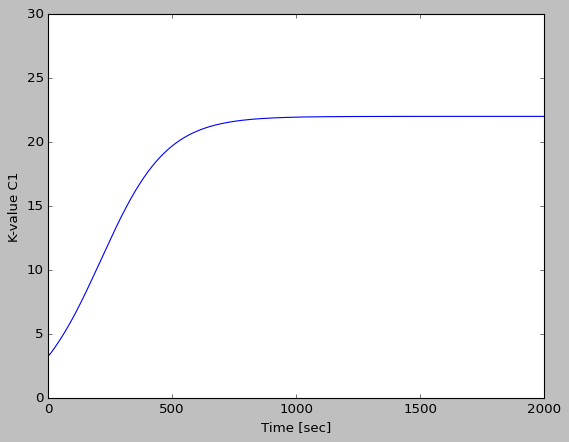

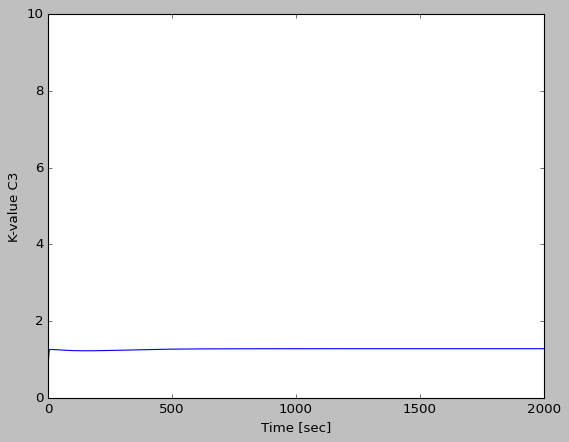

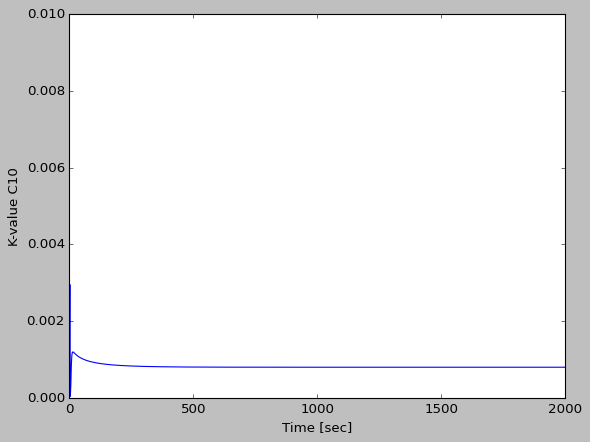

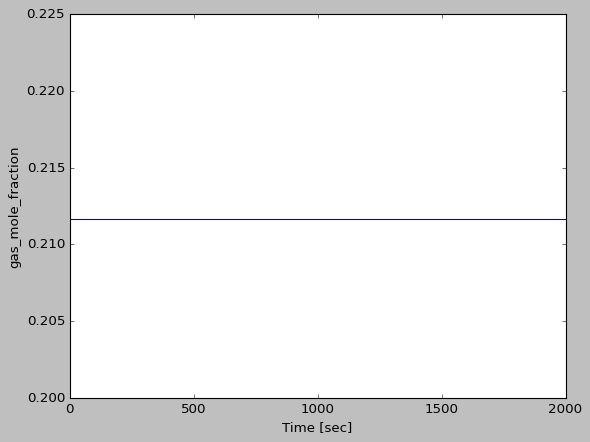

| 0                    | 1          | 2                  | 3                  | 4   | 5   | 6               |
|:---------------------|:-----------|:-------------------|:-------------------|:----|:----|:----------------|
|                      | total      | GAS                | OIL                |     |     |                 |
| methane              | 3.33518E-1 | 8.88218E-1         | 4.03838E-2         |     |     | [mole fraction] |
| ethane               | 3.32538E-2 | 6.5602E-2          | 1.61592E-2         |     |     | [mole fraction] |
| propane              | 3.88677E-2 | 4.54506E-2         | 3.53889E-2         |     |     | [mole fraction] |
| nC10                 | 5.94361E-1 | 7.29758E-4         | 9.08068E-1         |     |     | [mole fraction] |
|                      |            |                    |                    |     |     |                 |
| Density              |            | 7.19949E0          | 7.05908E2          |     |     | kg/m3           |
| Phase Fr

In [93]:
from neqsim import jNeqSim

from neqsim.thermo import TPflash

cell1 = jNeqSim.fluidMechanics.geometryDefinitions.stirredCell.StirredCell(2.0, 0.05);

testSystem = jNeqSim.thermo.system.SystemPrEos(313.3, 70.01325)
testSystem.addComponent("methane", 0.6457851061152181, "kg/min", 0)
testSystem.addComponent("ethane", 0.1206862204876, "kg/min", 1)
testSystem.addComponent("propane", 0.206862204876, "kg/min", 1)
testSystem.addComponent("nC10", 10.206862204876, "kg/min", 1)
testSystem.setMixingRule(2)
testSystem.initPhysicalProperties()

TPflash(testSystem)
printFrame(testSystem)

testSystem.setPressure(10.0)
testSystem.init(1)

test = jNeqSim.fluidMechanics.flowNode.twoPhaseNode.twoPhaseStirredCellNode.StirredCellNode(testSystem, cell1);
test.setInterphaseModelType(1);
test.getFluidBoundary().useFiniteFluxCorrection(True);
test.getFluidBoundary().useThermodynamicCorrections(True);
test.setStirrerSpeed(1.0);
test.setStirrerDiameter(0.05);
test.setDt(2.0);

test.initFlowCalc();

Kvalue_C1 = []
Kvalue_C3 = []
Kvalue_C10 = []
gas_mole_fraction = []
time = []

for i in range(1000):
  Kvalue_C1.append(test.getBulkSystem().getPhase(0).getComponent('methane').getx()/test.getBulkSystem().getPhase(1).getComponent('methane').getx())
  Kvalue_C3.append(test.getBulkSystem().getPhase(0).getComponent('propane').getx()/test.getBulkSystem().getPhase(1).getComponent('propane').getx())
  Kvalue_C10.append(test.getBulkSystem().getPhase(0).getComponent('nC10').getx()/test.getBulkSystem().getPhase(1).getComponent('nC10').getx())
  gas_mole_fraction.append(test.getBulkSystem().getPhase(0).getNumberOfMolesInPhase())
  time.append(i*test.getDt())
  test.initFlowCalc();
  test.calcFluxes();
  test.update();

import matplotlib.pyplot as plt

plt.plot(time, Kvalue_C1)
plt.ylim((0,30))
plt.xlabel('Time [sec]')
plt.ylabel('K-value C1')
plt.show()

plt.plot(time, Kvalue_C3)
plt.ylim((0,10))
plt.xlabel('Time [sec]')
plt.ylabel('K-value C3')
plt.show()

plt.plot(time, Kvalue_C10)
plt.xlabel('Time [sec]')
plt.ylabel('K-value C10')
plt.ylim((0,0.01))
plt.show()

plt.plot(time, gas_mole_fraction)
plt.xlabel('Time [sec]')
plt.ylabel('gas_mole_fraction')
plt.show()


TPflash(testSystem)
printFrame(testSystem)
